In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow
import parquet
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error

In [2]:
df = pd.read_parquet('kelusanka_2022_after imputing_missing.parquet')
df.set_index('ETD_DATE',inplace=True)
len(df)

4745

In [3]:
#df['DEMAND'].iloc[:91].plot(figsize = (12,6))

In [4]:
test_result=adfuller(df['DEMAND'])
test_result

(-6.604690483739862,
 6.601682224937323e-09,
 28,
 4716,
 {'1%': -3.4317373755182086,
  '5%': -2.862153061831011,
  '10%': -2.5670963349516307},
 42217.51523789547)

In [5]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(demand):
    result=adfuller(demand)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [6]:
adfuller_test(df['DEMAND'])

ADF Test Statistic : -6.604690483739862
p-value : 6.601682224937323e-09
#Lags Used : 28
Number of Observations Used : 4716
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [7]:
df['Seasonal First Difference']=df['DEMAND']-df['DEMAND'].shift(13)

In [8]:
df.head(15)

,ETD_TD_TIME,DEMAND,Seasonal First Difference
ETD_DATE,,,
2022-01-01,7,28,NaN
2022-01-01,8,70,NaN
2022-01-01,9,22,NaN
2022-01-01,10,14,NaN
2022-01-01,11,58,NaN
2022-01-01,12,46,NaN
2022-01-01,13,42,NaN
2022-01-01,14,15,NaN
2022-01-01,15,33,NaN


In [9]:
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -18.421438221187945
p-value : 2.175964112114022e-30
#Lags Used : 31
Number of Observations Used : 4700
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='ETD_DATE'>

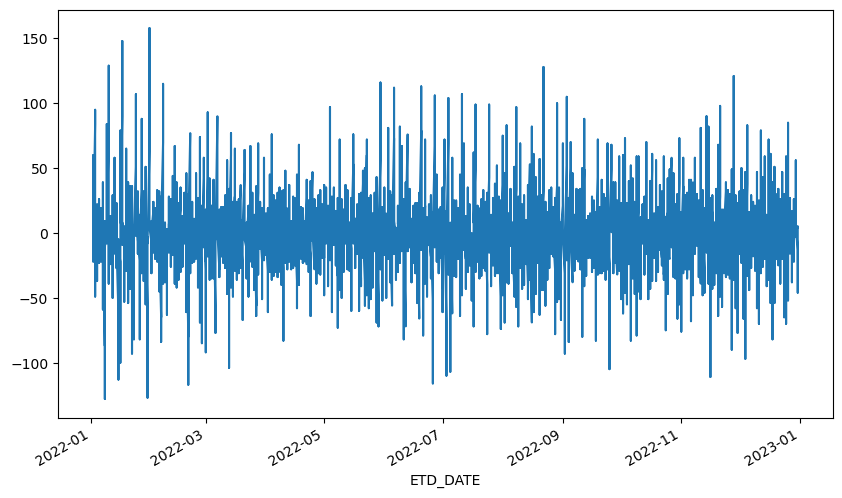

In [10]:
df['Seasonal First Difference'].plot(figsize = (10,6))

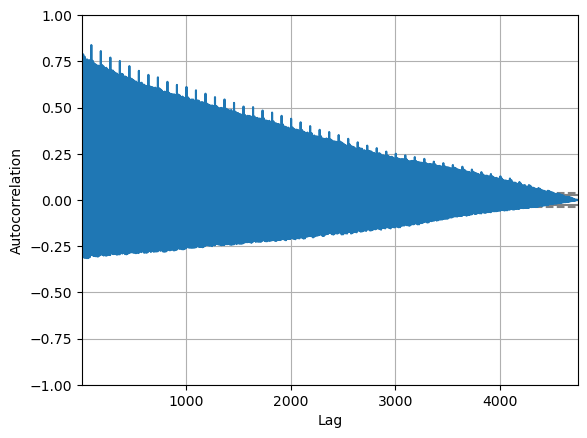

In [11]:
autocorrelation_plot(df['DEMAND'])
plt.show()

C:\Users\AMRUTH\.spss\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


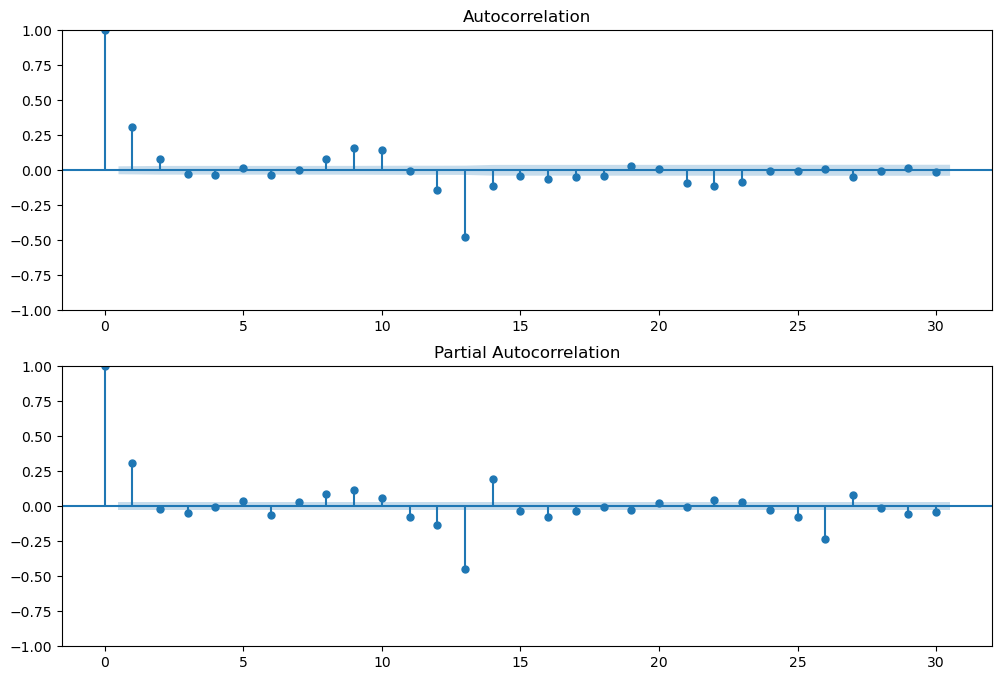

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=30,ax=ax2)

In [16]:
df = df.reset_index()
model1=sm.tsa.statespace.SARIMAX(df['DEMAND'],order=(1, 1, 2), seasonal_order=(0, 1, 2, 13))
results=model1.fit()

<AxesSubplot:>

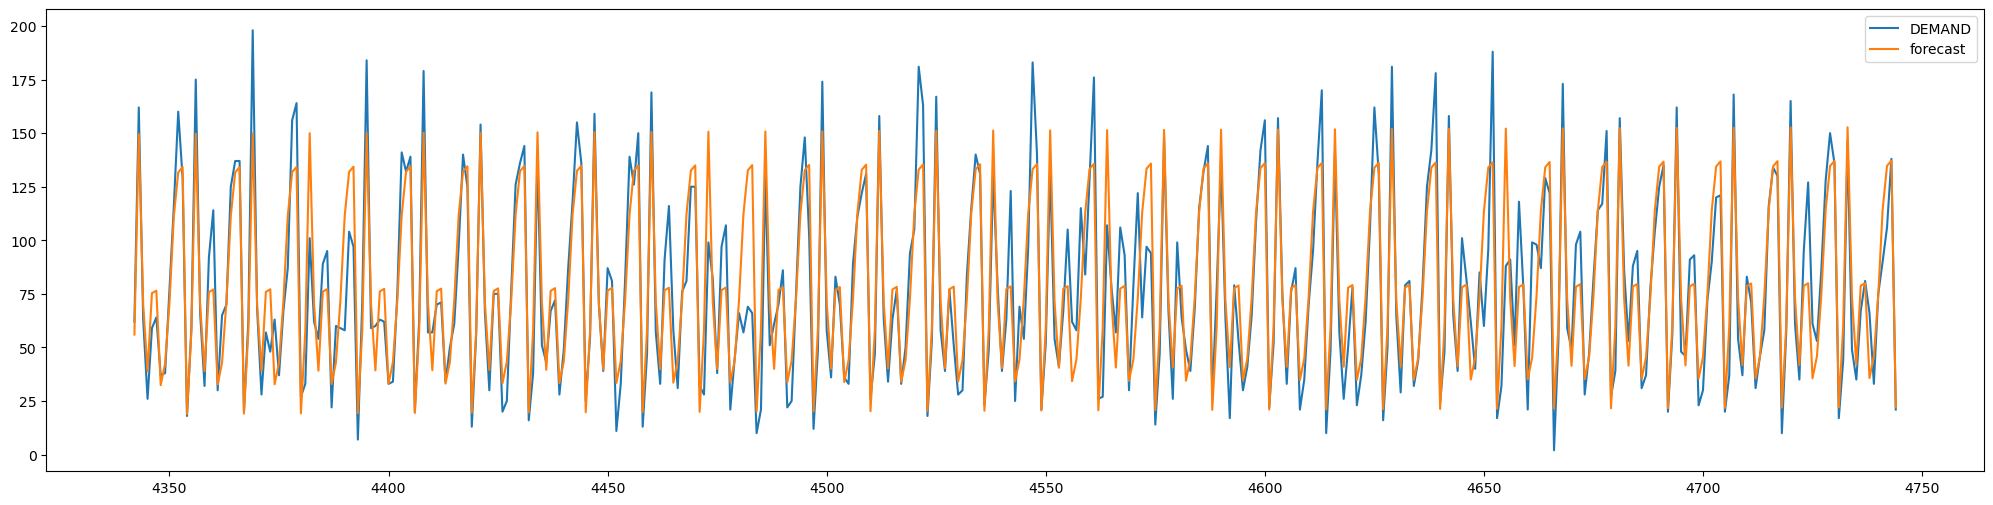

In [17]:
df['forecast']=results.predict(start=4342,end=4745,dynamic=True)
df[['DEMAND','forecast']].iloc[4342:].plot(figsize=(25,6))

In [18]:
df.tail(403)

,index,ETD_DATE,ETD_TD_TIME,DEMAND,Seasonal First Difference,forecast
4342,4342,2022-12-01,7,62,12.0,56.008245
4343,4343,2022-12-01,8,162,2.0,149.560872
4344,4344,2022-12-01,9,63,-16.0,70.215215
4345,4345,2022-12-01,10,26,-13.0,38.818143
4346,4346,2022-12-01,11,59,-2.0,75.318433
...,...,...,...,...,...,...
4740,4740,2022-12-31,15,75,-11.0,74.423247
4741,4741,2022-12-31,16,90,-38.0,114.302843
4742,4742,2022-12-31,17,106,-44.0,134.746631
4743,4743,2022-12-31,18,138,2.0,137.131038


In [19]:
rmse_daily = sqrt(mean_squared_error(df['DEMAND'].iloc[4342:],df['forecast'].iloc[4342:]))
print('rmse:',rmse_daily)
#MAPE should be less than 10
mape_daily = (1/len(df.iloc[4342:]))*np.sum(np.abs((df['DEMAND'].iloc[4342:]-df['forecast'].iloc[4342:])/df['DEMAND'].iloc[4342:]))*100
print('mape:',mape_daily)
print('mae:',mean_absolute_error(df['DEMAND'].iloc[4342:],df['forecast'].iloc[4342:]))
wmape_daily = np.sum((df['DEMAND'].iloc[4342:]/np.sum(df['DEMAND'].iloc[4342:]))*(np.abs((df['DEMAND'].iloc[4342:]-df['forecast'].iloc[4342:])/df['DEMAND'].iloc[4342:])))*100
print('wmape:',wmape_daily)

rmse: 18.621189303523398
mape: 25.392980198555755
mae: 13.778106073920336
wmape: 17.609338918526877
